In [ ]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D, LSTM
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
import pandas as pd
df = pd.read_csv("/content/data.csv")

In [ ]:
df.dropna(subset=['Body'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['Headline'] = df['Headline'].str.lower()
df['Body'] = df['Body'].str.lower()
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,four ways bob corker skewered donald trump,image copyright getty images\non sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,linklater's war veteran comedy speaks to moder...,"london (reuters) - “last flag flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,trump’s fight with corker jeopardizes his legi...,the feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,egypt's cheiron wins tie-up with pemex for mex...,mexico city (reuters) - egypt’s cheiron holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,jason aldean opens 'snl' with vegas tribute,"country singer jason aldean, who was performin...",1


In [ ]:
import string
def remove_punctuations(text):
    punctuations = set(string.punctuation)
    text = str(text)
    # return text.translate(str.maketrans('', '', punctuations))
    return " ".join([word for word in text.split() if word not in punctuations])

df['Headline'] = df['Headline'].apply(lambda x: remove_punctuations(x))
df['Body'] = df['Body'].apply(lambda x: remove_punctuations(x))

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

df['Headline'] = df['Headline'].apply(lambda x: remove_stopwords(x))
df['Body'] = df['Body'].apply(lambda x: remove_stopwords(x))

In [ ]:
import re
def remove_spl_chars(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

df['Headline'] = df['Headline'].apply(lambda x: remove_spl_chars(x))
df['Body'] = df['Body'].apply(lambda x: remove_spl_chars(x))

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
def stem(text):
    stemmed_sentence = " ".join(stemmer.stem(word) for word in text.split())
    return stemmed_sentence

df['Headline'] = df['Headline'].apply(lambda x: stem(x))
df['Body'] = df['Body'].apply(lambda x: stem(x))

In [ ]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

df['Headline'] = df['Headline'].apply(lambda x: remove_url(x))
df['Body'] = df['Body'].apply(lambda x: remove_url(x))

In [ ]:
texts = []
labels = []
for i in range(3988):
    texts.append(df['Body'][i])
    labels.append(df['Label'][i])

print(len(texts))
len(labels)

3988


3988

In [ ]:
max_words = 10000
max_seq_length = 1000
# the percentage of train test split to be applied
validation_split = 0.2
# the dimension of vectors to be used
embedding_dim = 100
# filter sizes of the different conv layers
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 30
epochs = 20

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
word_index = tokenizer.word_index
len(word_index)

32035

In [ ]:
word_index

In [ ]:
data = pad_sequences(sequences, maxlen=max_seq_length)
labels = to_categorical(np.asarray(labels))

In [ ]:
label_index = {'Fake': 1, 'Not_Fake': 0}

In [ ]:
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

Shape of data tensor:  (3988, 1000)
Shape of label tensor:  (3988, 2)


In [ ]:
type(data)

numpy.ndarray

In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(validation_split * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
print(x_train.shape)
x_val.shape

(3191, 1000)


(797, 1000)

In [ ]:
x_train[0].shape

(1000,)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-12-30 14:27:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-30 14:27:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-30 14:27:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

data.csv	   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [ ]:
embeddings_idx = {}
f = open("glove.6B.100d.txt", encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_idx[word] = coefs
f.close()

In [ ]:
len(embeddings_idx)

400000

In [ ]:
len(word_index)

32035

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13739   ,  0.77890998,  0.80053997, ..., -0.61676002,
         0.44703001, -0.27967   ],
       [-0.13128   , -0.45199999,  0.043399  , ..., -0.30526   ,
        -0.045495  ,  0.56509   ],
       ...,
       [-0.12560999, -0.020344  , -0.31240001, ...,  0.38492   ,
        -0.55392998, -0.29003999],
       [-0.017809  ,  0.74079001,  0.37839001, ...,  0.23705   ,
        -0.41218999, -0.090674  ],
       [ 0.17927   ,  0.23128   , -0.55498999, ...,  0.43808001,
         0.15075   , -0.59816998]])

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_length,
                            trainable=False)

In [ ]:
inputs = Input(shape=(max_seq_length, ), dtype='int32')
embedding = embedding_layer(inputs)
embedding.shape

TensorShape([None, 1000, 100])

In [ ]:
reshaped_inp = Reshape((max_seq_length, embedding_dim, 1))(embedding)
reshaped_inp.shape

TensorShape([None, 1000, 100, 1])

In [ ]:
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding="valid", kernel_initializer='normal',
                activation='relu')(reshaped_inp)
maxpool_1 = MaxPool2D(pool_size=(max_seq_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_1.shape


TensorShape([None, 1, 1, 512])

In [ ]:
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding="valid", kernel_initializer='normal',
                activation='relu')(reshaped_inp)
maxpool_2 = MaxPool2D(pool_size=(max_seq_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_2.shape

TensorShape([None, 1, 1, 512])

In [ ]:
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding="valid", kernel_initializer='normal',
                activation='relu')(reshaped_inp)
maxpool_3 = MaxPool2D(pool_size=(max_seq_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_3)
maxpool_3.shape

TensorShape([None, 1, 1, 512])

In [ ]:
concatenated_tensor = Concatenate(axis=1)([maxpool_1, maxpool_2, maxpool_3])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='sigmoid')(dropout)

In [ ]:
output.shape

TensorShape([None, 2])

In [ ]:
import tensorflow as tf
model = Model(inputs=inputs, outputs=output)
with tf.device('/device:GPU:0'):
  adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 100)            3203600   ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1000, 100, 1)         0         ['embedding[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 998, 1, 512)          154112    ['reshape[0][0]']             
                                                                                              

In [ ]:
print("Traning Model...")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val))

Traning Model...
Epoch 1/20
107/107 [==============================] - 14s 84ms/step - loss: 0.8596 - accuracy: 0.6431 - val_loss: 0.3297 - val_accuracy: 0.8507
Epoch 2/20
107/107 [==============================] - 8s 72ms/step - loss: 0.4998 - accuracy: 0.8001 - val_loss: 0.1967 - val_accuracy: 0.9260
Epoch 3/20
107/107 [==============================] - 8s 73ms/step - loss: 0.3601 - accuracy: 0.8496 - val_loss: 0.1720 - val_accuracy: 0.9322
Epoch 4/20
107/107 [==============================] - 8s 73ms/step - loss: 0.2667 - accuracy: 0.8972 - val_loss: 0.1369 - val_accuracy: 0.9423
Epoch 5/20
107/107 [==============================] - 8s 74ms/step - loss: 0.2235 - accuracy: 0.9173 - val_loss: 0.1337 - val_accuracy: 0.9410
Epoch 6/20
107/107 [==============================] - 8s 75ms/step - loss: 0.1663 - accuracy: 0.9329 - val_loss: 0.1037 - val_accuracy: 0.9686
Epoch 7/20
107/107 [==============================] - 8s 75ms/step - loss: 0.1619 - accuracy: 0.9373 - val_loss: 0.1085 - va

In [ ]:
x_train.shape

(3191, 1000)

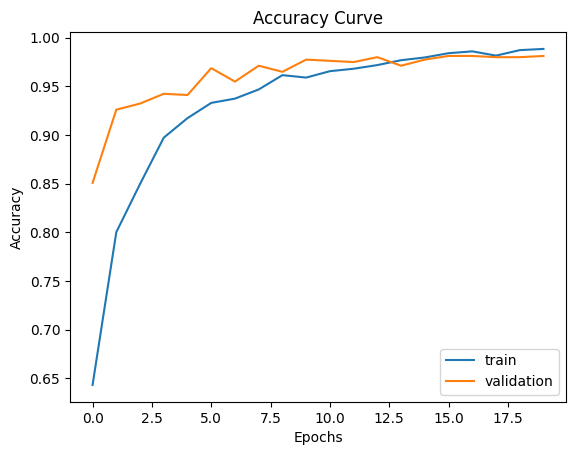

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

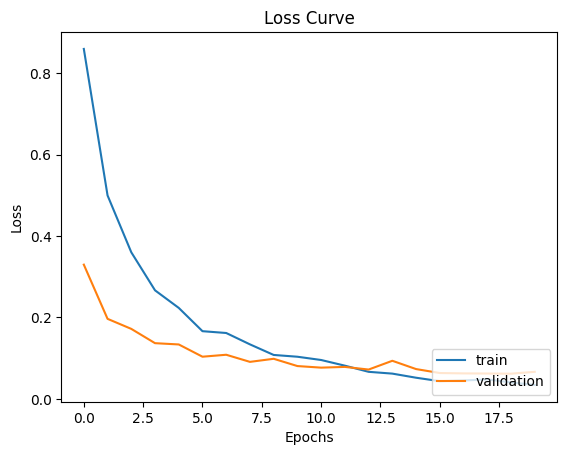

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

##Using RNN

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_seq_length])
    layer = Embedding(max_words,100,input_length=max_seq_length)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(2,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
from keras.optimizers import RMSprop

model_lstm = RNN()
model_lstm.summary()
with tf.device('/device:GPU:0'):
  model_lstm.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 2)                 514 

In [ ]:
from keras.callbacks import EarlyStopping

history_lstm = model_lstm.fit(x_train,y_train,batch_size=128,epochs=5, validation_split=0.2)

Epoch 1/5
20/20 [==============================] - 6s 166ms/step - loss: 0.6875 - accuracy: 0.5349 - val_loss: 0.6710 - val_accuracy: 0.5462
Epoch 2/5
20/20 [==============================] - 4s 188ms/step - loss: 0.5286 - accuracy: 0.8053 - val_loss: 0.3068 - val_accuracy: 0.9030
Epoch 3/5
20/20 [==============================] - 3s 132ms/step - loss: 0.2074 - accuracy: 0.9385 - val_loss: 0.0920 - val_accuracy: 0.9734
Epoch 4/5
20/20 [==============================] - 3s 144ms/step - loss: 0.0665 - accuracy: 0.9843 - val_loss: 0.0521 - val_accuracy: 0.9812
Epoch 5/5
20/20 [==============================] - 3s 135ms/step - loss: 0.0213 - accuracy: 0.9953 - val_loss: 0.0885 - val_accuracy: 0.9656


In [ ]:
model.predict(x_train)

100/100 [==============================] - 3s 24ms/step


array([[0.06546277, 0.98840034],
       [0.2679499 , 0.9404466 ],
       [0.99866927, 0.00810801],
       ...,
       [0.99931884, 0.01462547],
       [0.13716549, 0.9909733 ],
       [0.04990777, 0.99906534]], dtype=float32)

In [ ]:
x_train.shape

(3191, 1000)

In [ ]:
model_lstm.predict(x_train)

100/100 [==============================] - 2s 13ms/step


array([[0.037187  , 0.96311206],
       [0.04420813, 0.95543766],
       [0.99692684, 0.00392391],
       ...,
       [0.9989485 , 0.00141638],
       [0.01410934, 0.98572797],
       [0.00285375, 0.9972224 ]], dtype=float32)

In [ ]:
model.predict(x_val)

25/25 [==============================] - 1s 37ms/step


array([[0.14396492, 0.9947108 ],
       [0.07064423, 0.9975752 ],
       [0.1317237 , 0.99715793],
       ...,
       [0.99928445, 0.05695196],
       [0.99222493, 0.08140639],
       [0.99755776, 0.15784341]], dtype=float32)

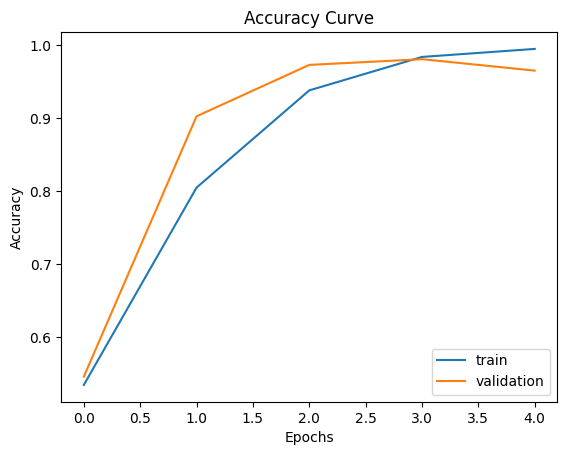

In [ ]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

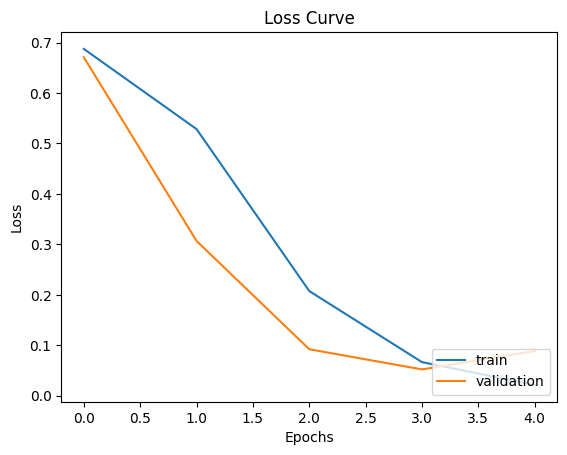

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
x_val.shape

(797, 1000)

In [ ]:
x_train[:1].shape

(1, 1000)

In [ ]:
model.predict(x_val[:1])

1/1 [==============================] - 0s 61ms/step


array([[0.14396481, 0.9947108 ]], dtype=float32)

In [ ]:
x_train

array([[   0,    0,    0, ...,   24, 1728, 1395],
       [   0,    0,    0, ...,  119,   87,  410],
       [   0,    0,    0, ..., 1579,  526, 5224],
       ...,
       [   0,    0,    0, ..., 2259,   15,   65],
       [   0,    0,    0, ..., 2193,  129,   46],
       [   0,    0,    0, ..., 1080,  811, 4143]], dtype=int32)

In [ ]:
a = np.array([[1]])

In [ ]:
a

array([[1]])

In [ ]:
!pip install h5py

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model_lstm_json = model_lstm.to_json()
with open("model_lstm_json.json", "w") as json_file:
    json_file.write(model_lstm_json)
# serialize weights to HDF5
model.save_weights("model_lstm.h5")
print("Saved model to disk")

Saved model to disk
